# Process
In this notebook, I will check whether other properties relate with popularity in the data.

# A. Import Libraries

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from split_users import split
from collections import Counter
from scipy import stats

# B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [21]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "ISBN" # the item column
user_col = "User-ID"
my_seed = 0 # random_seed
top_fraction_users = 0.2# the limit for a user to be considered High Preference
top_fraction_items = 0.2
split_popularity_by = "pop_fraq"
split_gender_by = "male_female_difference" 
split_country_by = "ratio_USA"

These additions will be useful so we can save the different files (plots and processed data) with clarity on the hyperparameters.

In [22]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_popularity_by=="pop_fraq") else "_sbpif")
addition_gender = addition_1 + "_tfu"+str(int(100*top_fraction_users))+  "_mfd"
addition_country = addition_1 + "_tfu"+str(int(100*top_fraction_users))+ "_USAr"
addition_birthyear = addition_1 + "_tfu"+str(int(100*top_fraction_users))+ "_1950r"

In [23]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

# C. Read files

In [24]:
processed_file_location = "data/processed/" # here we store the processed data files

### Gender

In [25]:
low_mp = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_gender+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")
med_mp = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_gender+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")
high_mp = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_gender+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")


### Country

In [26]:
low_Up = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_country+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")
med_Up = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_country+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")
high_Up = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_country+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")


### Birthyear

In [27]:
low_1950p = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_birthyear+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")
med_1950p = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_birthyear+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")
high_1950p = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_birthyear+"_new.csv", index_col=0, header=0, low_memory=False).fillna("")


### Popularity

In [28]:
df_item_dist= pd.read_csv(processed_file_location +recommendation_type + "/item_pop_dist"+addition_1+"_new.csv", index_col=0)

In [29]:
low_popularity = pd.read_csv(processed_file_location + recommendation_type +"/low_users"+addition_4+"_new.csv", index_col=0)
med_popularity = pd.read_csv(processed_file_location + recommendation_type +"/med_users"+addition_4+"_new.csv", index_col=0)
high_popularity = pd.read_csv(processed_file_location + recommendation_type +"/high_users"+addition_4+"_new.csv", index_col=0)

### Mapped ratings

In [30]:
mapped_ratings_with_properties = pd.read_csv(processed_file_location +recommendation_type + "/mapped_ratings_with_properties_new.csv", index_col=0)

In [31]:
mapped_ratings_with_properties

,User-ID,ISBN,Book-Rating,gender,country,birthyear
0,276847,0,10,female,UK,1950-2000
1,276847,1,10,female,UK,1950-2000
2,276847,2,10,female,UK,1950-2000
3,276847,3,10,female,UK,1950-2000
4,276964,4,10,male,USA,1900-1950
...,...,...,...,...,...,...
86351,276688,5443,7,female,USA,1900-1950
86352,276688,1465,6,female,USA,1900-1950
86353,276688,3655,8,female,USA,1950-2000
86354,276688,4244,10,male,USA,1950-2000


In [32]:
gender_dict = {}
country_dict = {}
birthyear_dict = {}
for isbn in mapped_ratings_with_properties.ISBN.unique():
    gender_dict[isbn] = mapped_ratings_with_properties.gender[mapped_ratings_with_properties.ISBN == isbn].iloc[0]
    country_dict[isbn] = mapped_ratings_with_properties.country[mapped_ratings_with_properties.ISBN == isbn].iloc[0]
    birthyear_dict[isbn] = mapped_ratings_with_properties.birthyear[mapped_ratings_with_properties.ISBN == isbn].iloc[0]

# D. Compare properties with 'popular' items

In [33]:
df_item_dist["gender"] = ""
df_item_dist["country"] = ""
df_item_dist["birthyear"] = ""

for index, row in df_item_dist.iterrows():
    gender = gender_dict[index]
    country = country_dict[index]
    birthyear = birthyear_dict[index]
    df_item_dist.at[index, "gender"] = gender
    df_item_dist.at[index, "country"] = country
    df_item_dist.at[index, "birthyear"] = birthyear

In [34]:
num_pop_items = int(top_fraction_items * len(df_item_dist))


The items that are considered popular:

In [35]:
pop_item_dist = df_item_dist.iloc[:num_pop_items]

### D1. Gender

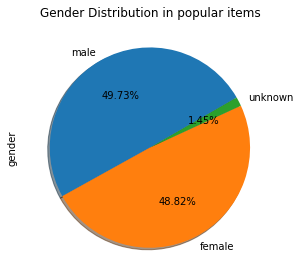

In [36]:
fig, ax = plt.subplots()
pop_item_dist.gender.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution in popular items")
fig.tight_layout()

In [37]:
pop_ratings = mapped_ratings_with_properties[mapped_ratings_with_properties.ISBN.isin(list(pop_item_dist.index))]

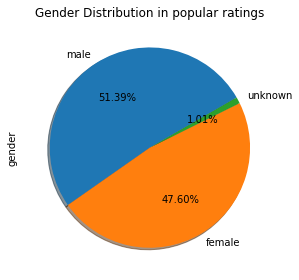

In [38]:
fig, ax = plt.subplots()
pop_ratings.gender.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Gender Distribution in popular ratings")
fig.tight_layout()

### D2. Country

In [39]:
colors={'USA':'#1f77b4', 
        'UK':'#d62728',
       "Ireland":"#8c564b",
       "unknown":"#ff7f0e",
       "Canada":"#9467bd",
       "other":"#2ca02c"}

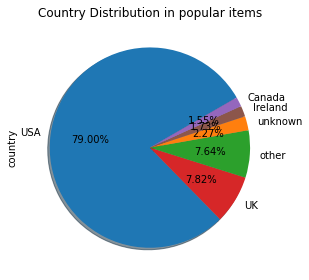

In [40]:
fig, ax = plt.subplots()
pop_item_dist.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30,
                                          colors=[colors[v] for v in pop_item_dist['country'].value_counts().keys()])
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in popular items")
fig.tight_layout()

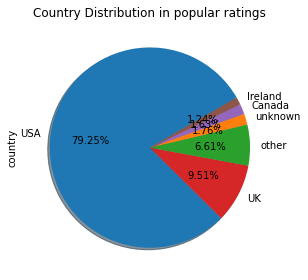

In [41]:
fig, ax = plt.subplots()
pop_ratings.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30,
                                          colors=[colors[v] for v in pop_ratings['country'].value_counts().keys()])
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in popular ratings")
fig.tight_layout()

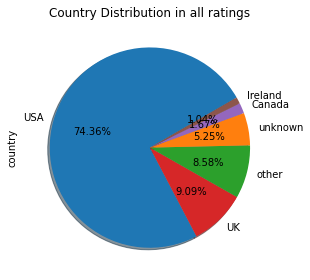

In [42]:
fig, ax = plt.subplots()
mapped_ratings_with_properties.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30,
                                          colors=[colors[v] for v in pop_ratings['country'].value_counts().keys()])
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in all ratings")
fig.tight_layout()

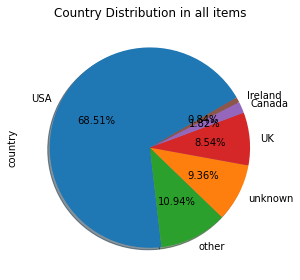

In [43]:
fig, ax = plt.subplots()
df_item_dist.country.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30,
                                          colors=[colors[v] for v in df_item_dist['country'].value_counts().keys()])
ax.tick_params(labelrotation=0)
ax.title.set_text("Country Distribution in all items")
fig.tight_layout()

In [44]:
df_item_dist.country.unique()

array(['USA', 'UK', 'other', 'Canada', 'unknown', 'Ireland'], dtype=object)

### D3. Birthyear

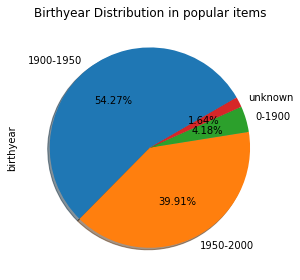

In [45]:
fig, ax = plt.subplots()
pop_item_dist.birthyear.value_counts().plot(kind="pie",autopct='%.2f%%', shadow=True
                                      , startangle=30)
ax.tick_params(labelrotation=0)
ax.title.set_text("Birthyear Distribution in popular items")
fig.tight_layout()

# E. Compare properties with popularity for items

Point biserial correlation

### E.1 Gender

In [46]:
df_item_dist_test = df_item_dist.copy()

In [47]:
df_item_dist_test.gender = df_item_dist_test.gender.apply(lambda x: 1 if x == "male" else 0)

In [48]:
stats.pointbiserialr(df_item_dist_test.gender.values, df_item_dist_test["count"].values)

PointbiserialrResult(correlation=0.034677067118359876, pvalue=0.010086650325668911)

### E.2 Country

In [49]:
df_item_dist_test = df_item_dist.copy()

In [50]:
df_item_dist_test.country = df_item_dist_test.country.apply(lambda x: 1 if x == "USA" else 0)

In [51]:
stats.pointbiserialr(df_item_dist_test.country.values, df_item_dist_test["count"].values)

PointbiserialrResult(correlation=0.0912897482687567, pvalue=1.158264841039079e-11)

### E.3 Birthyear

In [52]:
df_item_dist_test = df_item_dist.copy()

In [53]:
df_item_dist_test.birthyear = df_item_dist_test.birthyear.apply(lambda x: 1 if x == "1900-1950" else 0)

In [54]:
stats.pointbiserialr(df_item_dist_test.birthyear.values, df_item_dist_test["count"].values)

PointbiserialrResult(correlation=-0.011339910208964715, pvalue=0.4002740088511479)

### E.3 T test

In [55]:
df_non_unknowns = df_item_dist[df_item_dist.country!="unknown"]

#### E.3.a Gender

In [56]:
female_popularity = df_item_dist["count"][df_item_dist.gender == "female"].values
male_popularity = df_item_dist["count"][df_item_dist.gender == "male"].values

In [57]:
female_popularity.mean(), male_popularity.mean()

(0.0025430526230068133, 0.0025937988795426384)

In [58]:
stats.ttest_ind(female_popularity, male_popularity)

Ttest_indResult(statistic=-0.5132086877179234, pvalue=0.6078277150568246)

#### E.3.b Country

In [59]:
USA_popularity = df_item_dist["count"][df_item_dist.country == "USA"].values
nonUSA_popularity = df_item_dist["count"][df_item_dist.country != "USA"].values

In [60]:
USA_popularity.mean(), nonUSA_popularity.mean()

(0.0026799456148077928, 0.002010810170692695)

In [61]:
stats.ttest_ind(USA_popularity, nonUSA_popularity)

Ttest_indResult(statistic=6.799853420348795, pvalue=1.1582648410423848e-11)

In [62]:
USA_popularity = df_non_unknowns["count"][df_non_unknowns.country == "USA"].values
nonUSA_popularity = df_non_unknowns["count"][df_non_unknowns.country != "USA"].values

In [63]:
USA_popularity.mean(), nonUSA_popularity.mean()

(0.0026799456148077928, 0.0022747911533688193)

In [64]:
stats.ttest_ind(USA_popularity, nonUSA_popularity)

Ttest_indResult(statistic=3.4805615971537867, pvalue=0.0005046494342344799)

#### E.3.c Birthyear

In [65]:
popularity_1950 = df_item_dist["count"][df_item_dist.birthyear == "1900-1950"].values
popularity_non1950 = df_item_dist["count"][df_item_dist.birthyear != "1900-1950"].values

In [66]:
popularity_1950.mean(), popularity_non1950.mean()

(0.0024317338289449684, 0.0025089761418610195)

In [67]:
stats.ttest_ind(popularity_1950, popularity_non1950)

Ttest_indResult(statistic=-0.8411972307888649, pvalue=0.40027400885277986)

# E. Compare properties with average popularity for users

In [68]:
full_gender_df = pd.concat([low_mp, med_mp, high_mp])
full_country_df = pd.concat([low_Up, med_Up, high_Up])
full_pop_df = pd.concat([low_popularity, med_popularity, high_popularity])

In [69]:
final_df = pd.merge(pd.merge(full_gender_df.male_female_difference, full_country_df.ratio_USA, left_index=True, right_index=True), full_pop_df, left_index=True, right_index=True)

In [70]:
final_df.head()

,male_female_difference,ratio_USA,count,pop_count,user_hist,pop_fraq,pop_item_fraq
276847,-1.0,0.0,4,0,4,0.000000,0.000826
211961,-1.0,1.0,9,2,9,0.222222,0.005281
214348,-1.0,1.0,5,3,5,0.600000,0.002550
217444,-1.0,1.0,5,5,5,1.000000,0.005697
54512,-1.0,1.0,5,1,5,0.200000,0.002109


### E.1 Country

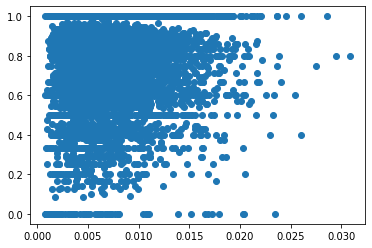

In [71]:
plt.scatter(final_df.pop_item_fraq.values, final_df.ratio_USA.values)

In [72]:
stats.pearsonr(final_df.pop_fraq.values, final_df.ratio_USA.values)[0]

0.16172099960111236

### E.2 Gender

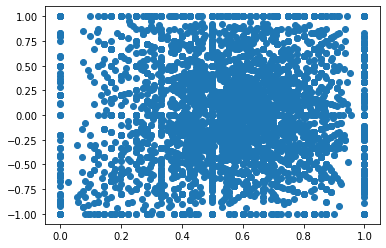

In [73]:
plt.scatter(final_df.pop_fraq.values, final_df.male_female_difference.values)

In [74]:
stats.pearsonr(final_df.pop_fraq.values, final_df.male_female_difference.values)[0]

0.006363222868634572

# F. Analyze properties for every popularity user group

In [75]:
low_popularity["male_female_difference"] = ""
low_popularity["ratio_USA"] = ""
med_popularity["male_female_difference"] = ""
med_popularity["ratio_USA"] = ""
high_popularity["male_female_difference"] = ""
high_popularity["ratio_USA"] = ""

In [76]:
for index, row in low_popularity.iterrows():
    mfd = full_gender_df.loc[index].male_female_difference
    rU = full_country_df.loc[index].ratio_USA
    
    low_popularity.at[index, "male_female_difference"] = mfd
    low_popularity.at[index, "ratio_USA"] = rU

In [77]:
for index, row in med_popularity.iterrows():
    mfd = full_gender_df.loc[index].male_female_difference
    rU = full_country_df.loc[index].ratio_USA
    
    med_popularity.at[index, "male_female_difference"] = mfd
    med_popularity.at[index, "ratio_USA"] = rU

In [78]:
for index, row in high_popularity.iterrows():
    mfd = full_gender_df.loc[index].male_female_difference
    rU = full_country_df.loc[index].ratio_USA
    
    high_popularity.at[index, "male_female_difference"] = mfd
    high_popularity.at[index, "ratio_USA"] = rU

Let's see!

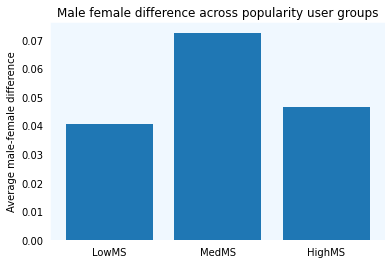

In [79]:
plt.figure()
ax = plt.axes()
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['left'].set_zorder(0)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
plt.xticks(np.arange(3), ['LowMS', 'MedMS', 'HighMS'])
ax.set_facecolor("aliceblue")
ylabel = 'Average male-female difference'
plt.ylabel(ylabel)
plt.bar(np.arange(3), [low_popularity.male_female_difference.mean(),med_popularity.male_female_difference.mean(),high_popularity.male_female_difference.mean()])
plt.title("Male female difference across popularity user groups")
plt.show()

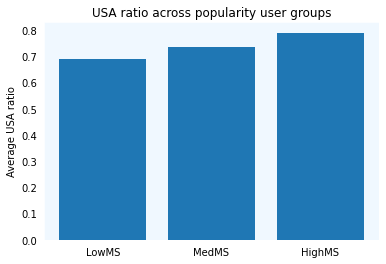

In [80]:
plt.figure()
ax = plt.axes()
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['left'].set_zorder(0)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none') 
plt.xticks(np.arange(3), ['LowMS', 'MedMS', 'HighMS'])
ax.set_facecolor("aliceblue")
ylabel = 'Average USA ratio'
plt.ylabel(ylabel)
plt.bar(np.arange(3), [low_popularity.ratio_USA.mean(),med_popularity.ratio_USA.mean(),high_popularity.ratio_USA.mean()])
plt.title("USA ratio across popularity user groups")
plt.show()